# Initial setup
- Library imports
- Utility functions

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from glob import glob
import os
from joblib import Parallel, delayed

from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn 
from torch.utils.data import Dataset

In [2]:
LANES = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]

with open(os.path.join("game_data", "items.json"), "r", encoding="utf-8") as fp:
    item_dict = json.load(fp)
    ITEMS = {
        item_id: item_info
        for item_id, item_info in item_dict.items()
        if item_info["tier"] >= 3 or (item_info["tier"] == 2 and \
            ("BOOTS" in item_info["rank"] or item_info["id"] in [3004, 3003, 3119, 3010, 3866])) or \
            ("STARTER" in item_info["rank"])
    }

with open(os.path.join("game_data", "champions.json"), "r", encoding="utf-8") as fp:
    CHAMP_DICT = json.load(fp)
    CHAMP_NAME_TO_ID = {c: CHAMP_DICT[c]["id"] for c in CHAMP_DICT.keys()}
    CHAMP_ID_TO_NAME = {CHAMP_DICT[c]["id"]: c for c in CHAMP_DICT.keys()}
    CHAMPION_ICONS = {c: CHAMP_DICT[c]["icon"] for c in CHAMP_DICT.keys()}

with open(os.path.join("game_data", "perks.json"), "r", encoding="utf-8") as fp:
    PERK_ID_TO_NAME = json.load(fp)

def get_item_name(item_id: int):
    return ITEMS.get(str(int(item_id)), "").get("name")

def get_item_icon(item_id: int):
    if not item_id:
        return None
    url = ITEMS.get(str(int(item_id)), {}).get("icon", "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/data/spells/icons2d/summoner_empty.png")
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

def get_champion_id(champion_name: str):
    if champion_name is None:
        return None
    return CHAMP_NAME_TO_ID.get(champion_name, "")

def get_champion_name(champion_id: int):
    return CHAMP_ID_TO_NAME.get(champion_id)

def get_champion_icon(champion_name: int):
    if not champion_name:
        return None
    url = CHAMPION_ICONS.get(champion_name)
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

# Pre-processing

## Numeric feature normalization

In [3]:
dataset_folder = os.path.join("features", "dataset", "timeline")
small_folder = os.path.join(dataset_folder, "small")
norm_folder = os.path.join(dataset_folder, "normalized")
max_matches = 2000

In [ ]:
numeric_cols = [
    "kda", "level", "goldEarned", "minionsKilled", "tier", "timeframe",
] + [
    f"ally_{i}_kda" for i in range(4)
]+ [
    f"enemy_{i}_kda" for i in range(5)
] + [
    f"ally_{i}_level" for i in range(4)
] + [
    f"enemy_{i}_level" for i in range(5)
] + [
    f"ally_{i}_minionsKilled" for i in range(4)
]+ [
    f"enemy_{i}_minionsKilled" for i in range(5)
] + [
    f"ally_{feature}" for feature in ["voidgrubKills","atakhanKills","baronKills","dragonKills","structuresKilled","heraldKills",]
] + [
    f"enemy_{feature}" for feature in ["voidgrubKills","atakhanKills","baronKills","dragonKills","structuresKilled","heraldKills",]
] + [
    f"skills_{i}" for i in range(4)
]

os.makedirs(os.path.join(dataset_folder, "small"), exist_ok=True)
all_mins = []
all_maxs = []
# Find min and max for each numeric feature across every file
for path in glob(os.path.join(dataset_folder, "*.parquet")):
    df = pd.read_parquet(path)
    df = df.drop(columns=[f"items_{i}" for i in range(6)])  # Drop unnecessary columns
    # Count number of timeframes for each match
    match_lengths = df.groupby("matchId").size().rename("n_timeframes").reset_index()
    # Calculate how many matches to take for each origin
    match_origin = df[["matchId", "origin"]].drop_duplicates()
    match_stats = pd.merge(match_lengths, match_origin, on="matchId")
    origin_counts = match_stats["origin"].value_counts()
    total = origin_counts.sum()
    sample_per_origin = (origin_counts / total * max_matches).round().astype(int)
    # Filter dataframe to have only max_matches
    sampled_ids = []
    for origin, count in sample_per_origin.items():
        origin_matches = match_stats[match_stats["origin"] == origin]
        top_matches = origin_matches.sort_values("n_timeframes", ascending=False).head(count)
        sampled_ids.extend(top_matches["matchId"].tolist())
    df = df[df["matchId"].isin(sampled_ids)]
    # Find min-max values
    stats = df[numeric_cols].agg(["min", "max"])
    all_mins.append(stats.loc["min"])
    all_maxs.append(stats.loc["max"])
    # Store the new, smaller df
    out_path = os.path.join(small_folder, path.split(os.sep)[-1])
    df.to_parquet(out_path)

global_min = pd.concat(all_mins, axis=1).min(axis=1)
global_max = pd.concat(all_maxs, axis=1).max(axis=1)

os.makedirs(norm_folder, exist_ok=True)
# Min-max normalization, then store again
for path in glob(os.path.join(small_folder, "*.parquet")):
    df = pd.read_parquet(path)
    df[numeric_cols] = (df[numeric_cols] - global_min) / (global_max - global_min + 1e-6)
    out_path = os.path.join(norm_folder, path.split(os.sep)[-1])
    df.to_parquet(out_path)

In [5]:
# Input features for the RNN
model_cols = df.drop(columns=["participantId", "matchId", "origin"]).columns
feature_cols = [col for col in model_cols if "items" not in col]
item_cols = [col for col in model_cols if "item_" in col]

io_dir = os.path.join(dataset_folder, "model_io_files")
os.makedirs(io_dir, exist_ok=True)
# Paralelize processing to build I/O files for the model
paths = glob(os.path.join(norm_folder, "*.parquet"))

In [6]:
def extract_sequence_and_labels(group, feature_cols, item_cols):
    group = group.sort_values("timeframe").reset_index(drop=True)
    # At least 3 timeframes (equivalent to 3 items)
    if len(group) < 3:
        return None
    # Insert a game-start row if needed
    if group.iloc[0][item_cols].sum() > 0:
        first_row = group.iloc[0].copy()
        first_row[item_cols] = 0
        first_row["goldEarned"] = 500
        first_row["timeframe"] = 0
        group = pd.concat([pd.DataFrame([first_row]), group], ignore_index=True)
    # 1 on the column where item was bought, -1 where it was sold
    item_matrix = group[item_cols].to_numpy(dtype=np.float32)
    item_diff = item_matrix[1:] - item_matrix[:-1]
    item_diff[item_diff < 0] = 0  # remove sold items
    # Has to have exactly one item bought
    mask = (item_diff.sum(axis=1) == 1)
    # Define feature dataframes
    x = group.iloc[:-1].loc[mask, feature_cols].reset_index(drop=True)
    y = pd.DataFrame(item_diff[mask], columns=item_cols).reset_index(drop=True)
    return x, y

def process_file(path, out_dir, feature_cols, item_cols):
    df = pd.read_parquet(path)
    df = df.sort_values(["matchId", "participantId", "timeframe"])
    grouped = df.groupby(["matchId", "participantId"], sort=False)
    records = []
    for (match_id, participant_id), group in grouped:
        origin = group["origin"].iloc[0] if "origin" in group.columns else None
        result = extract_sequence_and_labels(group, feature_cols, item_cols)
        if result is None:
            continue
        x, y = result
        if len(x) != len(y):
            continue
        records.append({
            "matchId": match_id,
            "participantId": participant_id,
            "origin": origin,
            "x": x.to_dict(orient="records"),  # list of {col: val}
            "y": y.to_dict(orient="records")
        })
    if not records:
        return None
    df_out = pd.DataFrame(records)
    filename = os.path.basename(path).replace(".parquet", "_processed.parquet")
    out_path = os.path.join(out_dir, filename)
    df_out.to_parquet(out_path, index=False)
    print(f"Saved: {out_path}")
    return out_path, len(df_out)

#index_entries = process_file(paths[0], io_dir, feature_cols, item_cols)
from multiprocessing.dummy import Pool as ThreadPool

with ThreadPool(4) as pool:
    index_entries = pool.map(lambda p: process_file(p, io_dir, feature_cols, item_cols), paths)

# Maps where each file ended up
pd.DataFrame(index_entries).to_csv(os.path.join(io_dir, "index.csv"), index=False)

Saved: features\dataset\timeline\model_io_files\2500_2999_processed.parquet
Saved: features\dataset\timeline\model_io_files\1500_1999_processed.parquet
Saved: features\dataset\timeline\model_io_files\2000_2499_processed.parquet
Saved: features\dataset\timeline\model_io_files\1000_1499_processed.parquet
Saved: features\dataset\timeline\model_io_files\3000_3499_processed.parquet
Saved: features\dataset\timeline\model_io_files\4000_4499_processed.parquet
Saved: features\dataset\timeline\model_io_files\3500_3999_processed.parquet
Saved: features\dataset\timeline\model_io_files\4500_4999_processed.parquet
Saved: features\dataset\timeline\model_io_files\5000_5499_processed.parquet
Saved: features\dataset\timeline\model_io_files\5500_5999_processed.parquet
Saved: features\dataset\timeline\model_io_files\500_999_processed.parquet
Saved: features\dataset\timeline\model_io_files\6000_6499_processed.parquet
Saved: features\dataset\timeline\model_io_files\6500_6999_processed.parquet
Saved: feature

## Defining the dataset

In [7]:
class TimelineDataset(Dataset):
    def __init__(self, dataset_dir):
        self.samples = []  # Each sample is (x_tensor, y_tensor, metadata)
        self.columns = []
        self.items = []

        for file in glob(os.path.join(dataset_dir, "*.parquet")):
            try:
                df = pd.read_parquet(file)
            except Exception as e:
                print(e)
                break

            for idx, row in df.iterrows():
                match_id = row["matchId"]
                participant_id = row["participantId"]
                origin = row["origin"]
                x_rows = row["x"]
                y_rows = row["y"]

                x_tensor = torch.tensor([list(x.values()) for x in x_rows], dtype=torch.float32)
                y_tensor = torch.tensor([list(y.values()) for y in y_rows], dtype=torch.float32)

                if len(x_tensor) == 0 or len(y_tensor) == 0:
                    continue

                self.samples.append(
                    (x_tensor, y_tensor,
                     {
                        "matchId": match_id,
                        "participantId": participant_id,
                        "origin": origin}
                    )
                )

            if not self.columns:
                self.columns = list(df.loc[0, "x"][0].keys())
                self.items = list(df.loc[0, "y"][0].keys())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, meta = self.samples[idx]
        return (x, y), meta

In [8]:
def collate_pad(batch):
    (xs, ys) = zip(*[batch[i][0] for i in range(len(batch))])  # Lists of (T_i, F), (T_i, 136)

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feature_dim = xs[0].shape[1]
    num_classes = ys[0].shape[1]

    padded_x = torch.zeros(len(xs), max_len, feature_dim)
    padded_y = torch.zeros(len(xs), max_len, num_classes)
    mask = torch.zeros(len(xs), max_len)

    for i, (x, y) in enumerate(zip(xs, ys)):
        seq_len = x.shape[0]
        padded_x[i, :seq_len] = x
        padded_y[i, :seq_len] = y
        mask[i, :seq_len] = 1

    return padded_x, padded_y, mask

In [9]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

dataset = TimelineDataset(io_dir)
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=37)

In [187]:
def visualize_dataset(dataset, n):
    i = 0
    while i < n:
        matchId = dataset[i][1].get("matchId")
        participantId = dataset[i][1].get("participantId")
        print(f"\n{'='*20} match {matchId} - participant {participantId} {'='*20}")
        while dataset[i][1].get("matchId") == matchId and dataset[i][1].get("participantId") == participantId:
            x, y = dataset[i][0]
            cols = dataset.columns
            items = dataset.items

            for tx, ty in zip(x, y):
                x = pd.Series(data=tx, index=cols)
                print(f"Timeframe {x['timeframe']}")
                built = []
                for col in [c for c in cols if "item" in c]:
                    if x[col] == 1:
                        built.append(col)
                print(f"{'Built items:':<15}", ", ".join(built))
                for idx, value in enumerate(ty):
                    if value == 1:
                        print(f"{'Next item:':<15}", items[idx])
                print()

            i += 1

visualize_dataset(dataset, 1)


==================== match BR1_3102083317 - participant 3 ====================
Timeframe 0.0
Built items:    
Next item:      item_1082

Timeframe 5.225281256571179e-06
Built items:    item_1082
Next item:      item_3020

Timeframe 0.06535651534795761
Built items:    item_1082, item_3020
Next item:      item_3100

Timeframe 0.15682092308998108
Built items:    item_1082, item_3020, item_3100
Next item:      item_4645

Timeframe 0.26136314868927
Built items:    item_3020, item_3100, item_4645
Next item:      item_3157



In [274]:
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=37)
train_val_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)
print(f"Training examples: {len(train_val_ds)}")
print(f"Test examples: {len(test_ds)}")

Training examples: 201249
Test examples: 50313


# RNN

## Training

In [ ]:
class TimelineRNN(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_layers=5, output_size=136):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        return self.fc(unpacked)  # (B, T, I)

In [14]:
from sklearn.model_selection import KFold

criterion = nn.CrossEntropyLoss()
k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=37)
indices = list(range(len(dataset)))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
max_epochs = 50
patience = 3

all_val_losses = []
all_train_losses = []

# 3-fold CV
for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\nFold {fold + 1}")

    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_pad)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, collate_fn=collate_pad)

    model = TimelineRNN(input_size=dataset[0][0][0].shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float("inf")
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(max_epochs + 1):
        model.train()
        total_train_loss = 0

        for x, y, mask in train_loader:
            # Move to device
            x, y, mask = x.to(device), y.to(device), mask.to(device)
            lengths = mask.sum(1).long()
            optimizer.zero_grad()
            logits = model(x, lengths)  # (B, T, I)
            # Convert y to class indices
            targets = y.argmax(dim=-1)  # (B, T)
            # Flatten all for masking
            logits = logits.view(-1, logits.shape[-1])     # (B*T, I)
            targets = targets.view(-1)                     # (B*T,)
            mask = mask.view(-1).bool()                    # (B*T,)
            # Apply mask
            logits = logits[mask]
            targets = targets[mask]
            # Calculate loss and back-propagate
            loss = criterion(logits, targets)
            total_train_loss += loss
            loss.backward()
            optimizer.step()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y, mask in val_loader:
                # Move to device
                x, y, mask = x.to(device), y.to(device), mask.to(device)
                lengths = mask.sum(1).long()
                logits = model(x, lengths)  # (B, T, I)
                # Convert y to class indices
                targets = y.argmax(dim=-1)  # (B, T)
                # Flatten all for masking
                logits = logits.view(-1, logits.shape[-1])     # (B*T, I)
                targets = targets.view(-1)                     # (B*T,)
                mask = mask.view(-1).bool()                    # (B*T,)
                # Apply mask
                logits = logits[mask]
                targets = targets[mask]
                loss = criterion(logits, targets)
                total_val_loss += loss

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Save the best model for each fold
    torch.save(best_model_state, f"model_fold{fold + 1}.pt")
    print(f"Best val loss for fold {fold + 1}: {best_val_loss:.4f}")


Fold 1
Fold 1, Epoch 1, Train Loss: 2.0395, Val Loss: 1.6775
Fold 1, Epoch 2, Train Loss: 1.6124, Val Loss: 1.5761
Fold 1, Epoch 3, Train Loss: 1.5419, Val Loss: 1.5404
Fold 1, Epoch 4, Train Loss: 1.5033, Val Loss: 1.5150
Fold 1, Epoch 5, Train Loss: 1.4775, Val Loss: 1.5063
Fold 1, Epoch 6, Train Loss: 1.4568, Val Loss: 1.4923
Fold 1, Epoch 7, Train Loss: 1.4415, Val Loss: 1.4927
Fold 1, Epoch 8, Train Loss: 1.4285, Val Loss: 1.4845
Fold 1, Epoch 9, Train Loss: 1.4160, Val Loss: 1.4809
Fold 1, Epoch 10, Train Loss: 1.4066, Val Loss: 1.4889
Fold 1, Epoch 11, Train Loss: 1.3965, Val Loss: 1.4928
Fold 1, Epoch 12, Train Loss: 1.3883, Val Loss: 1.4838
Early stopping.
Best val loss for fold 1: 1.4809

Fold 2
Fold 2, Epoch 1, Train Loss: 2.0449, Val Loss: 1.6771
Fold 2, Epoch 2, Train Loss: 1.6099, Val Loss: 1.5760
Fold 2, Epoch 3, Train Loss: 1.5408, Val Loss: 1.5506
Fold 2, Epoch 4, Train Loss: 1.5026, Val Loss: 1.5245
Fold 2, Epoch 5, Train Loss: 1.4774, Val Loss: 1.5164
Fold 2, Epoch 

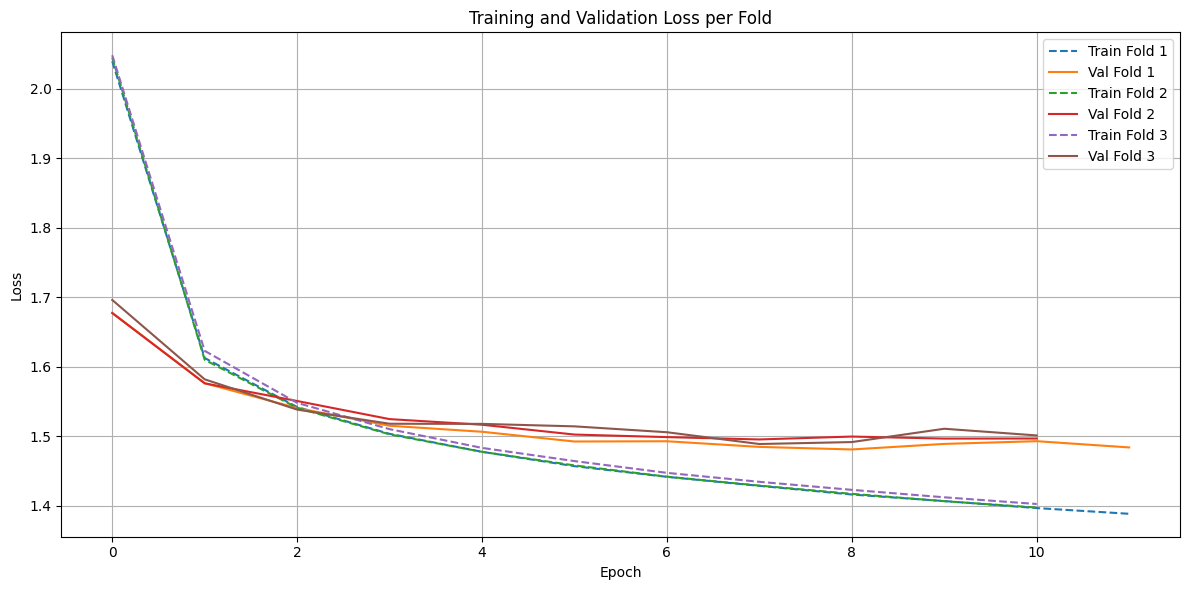

In [16]:
# Plotting after training
plt.figure(figsize=(12, 6))
for fold in range(3):
    plt.plot([l.cpu().detach().numpy() for l in all_train_losses[fold]], label=f'Train Fold {fold+1}', linestyle='--')
    plt.plot([l.cpu().detach().numpy() for l in all_val_losses[fold]], label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
model = TimelineRNN(input_size=dataset[0][0][0].shape[1]).to(device)
model.load_state_dict(torch.load("model_fold3.pt"))

<All keys matched successfully>

## Testing

In [281]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_micro_macro_metrics(recommendations, true_items):
    macro_precision, macro_recall, macro_f1 = [], [], []
    micro_tp = 0
    micro_fp = 0
    micro_fn = 0

    for pred_ids, true_ids in zip(recommendations, true_items):
        if not true_ids or not pred_ids:
            continue

        # Convert to numpy for comparison
        y_true = true_ids
        y_pred = pred_ids

        # === Macro ===
        p = precision_score(y_true, y_pred, average="macro", zero_division=0)
        r = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f = f1_score(y_true, y_pred, average="macro", zero_division=0)

        macro_precision.append(p)
        macro_recall.append(r)
        macro_f1.append(f)

        # === Micro ===
        for yt, yp in zip(y_true, y_pred):
            if yp == yt:
                micro_tp += 1
            else:
                micro_fp += 1
                micro_fn += 1

    # Micro scores (aggregated over all predictions)
    micro_precision = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) > 0 else 0
    micro_recall = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) > 0 else 0
    micro_f1 = (2 * micro_precision * micro_recall / (micro_precision + micro_recall)
                if (micro_precision + micro_recall) > 0 else 0)

    # Macro scores (mean of match-level metrics)
    macro_metrics = {
        "macro_precision": sum(macro_precision) / len(macro_precision) if macro_precision else 0,
        "macro_recall": sum(macro_recall) / len(macro_recall) if macro_recall else 0,
        "macro_f1": sum(macro_f1) / len(macro_f1) if macro_f1 else 0,
    }

    micro_metrics = {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
    }

    return {**macro_metrics, **micro_metrics}

def item_match_rate(recommendations, true_items):
    total = 0
    for pred_ids, true_ids in zip(recommendations, true_items):
        total += sum([1 for item in pred_ids if item in true_ids]) / len(pred_ids)
    return total / len(recommendations)

def relaxed_order_score(recommendations, true_items):
    total = 0
    for pred_ids, true_ids in zip(recommendations, true_items):
        score = 0
        already_seen = []
        for i, item in enumerate(pred_ids):
            if item not in already_seen and item in true_ids:
                true_index = true_ids.index(item)
                dist = abs(true_index - i)
                score += 1 - (dist / len(true_ids))
            already_seen.append(item)
        total += score / len(pred_ids)
    return total / len(recommendations)

In [ ]:
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True, collate_fn=collate_pad)

recommendations = []
true_items = []
model.eval()
with torch.no_grad():
    for x, y, mask in test_loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        lengths = mask.sum(1).long()
        logits = model(x, lengths)
        # Predicted class per timestep
        x = x.cpu()
        preds = logits.argmax(dim=2).cpu()   # (B*T,)
        true = y.argmax(dim=2).cpu()         # (B*T,)
        for match_idx in range(x.shape[0]):
            match_x, match_preds, match_true = x[match_idx], preds[match_idx], true[match_idx]
            recommendations.append([int(dataset.items[int(label.cpu())].replace("item_", "")) for label in match_preds])
            true_items.append([int(dataset.items[int(label.cpu())].replace("item_", "")) for label in match_true])

In [285]:
metrics = compute_micro_macro_metrics(recommendations, true_items)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

macro_precision: 0.3364
macro_recall: 0.3606
macro_f1: 0.3389
micro_precision: 0.3290
micro_recall: 0.3290
micro_f1: 0.3290


In [286]:
# After fixing the code
print(f"Item match rate: {item_match_rate(recommendations, true_items)}")
print(f"Relaxed order score: {relaxed_order_score(recommendations, true_items)}")

Item match rate: 0.4461029209672838
Relaxed order score: 0.33806678569619114


## Visualizing the builds

In [ ]:
recommendations = []
true_items = []
timeframe_info = []

model.eval()
with torch.no_grad():
    i = 0
    for x, y, mask in test_loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        lengths = mask.sum(1).long()
        logits = model(x, lengths)
        # Predicted class per timestep
        x = x.cpu()
        preds = logits.argmax(dim=2).cpu()   # (B*T,)
        true = y.argmax(dim=2).cpu()         # (B*T,)
        for match_idx in range(x.shape[0]):
            match_x, match_preds, match_true = x[match_idx], preds[match_idx], true[match_idx]
            timeframe_info.append(
                [pd.Series(data=input_sequence, index=dataset.columns)
                for input_sequence in match_x
                ])
            recommendations.append([int(dataset.items[int(label.cpu())].replace("item_", "")) for label in match_preds])
            true_items.append([int(dataset.items[int(label.cpu())].replace("item_", "")) for label in match_true])
        if i == 5:
            break
        i += 1

Lane: Top
Rank: Silver
Champion: Sett
Allies: Leona, Malzahar, Naafiri, Xayah
Enemies: Irelia, Kaisa, Maokai, Syndra, Zyra


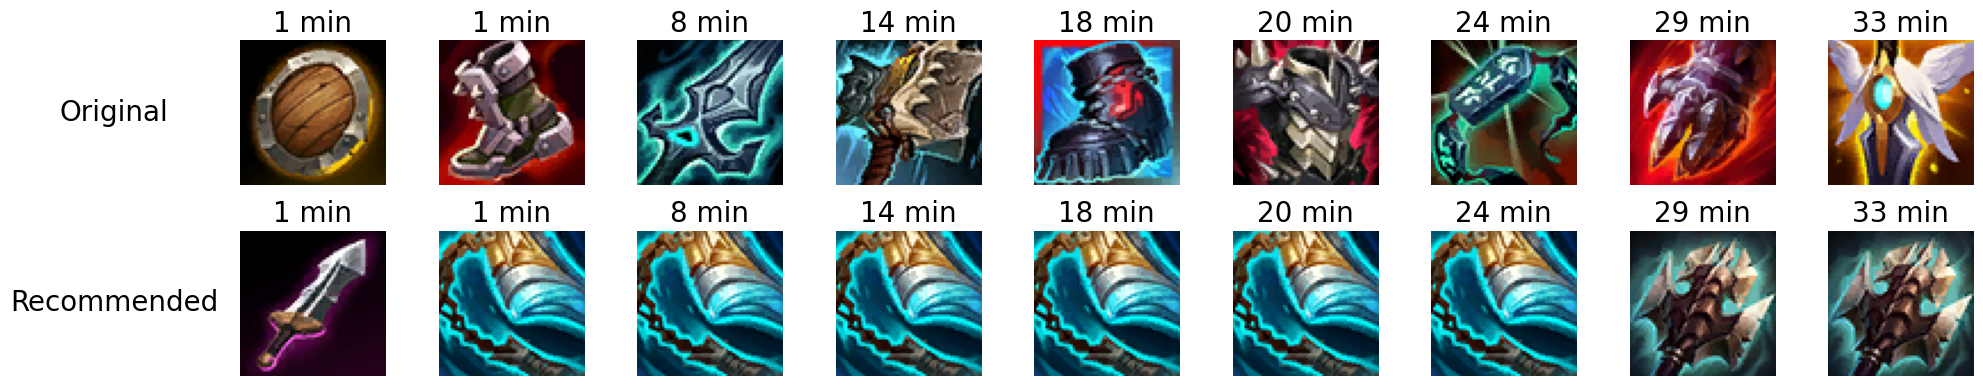

Lane: Middle
Rank: Master
Champion: Seraphine
Allies: Aatrox, TahmKench, Vayne, Zed
Enemies: Ambessa, Jinx, MasterYi, Milio, Xerath


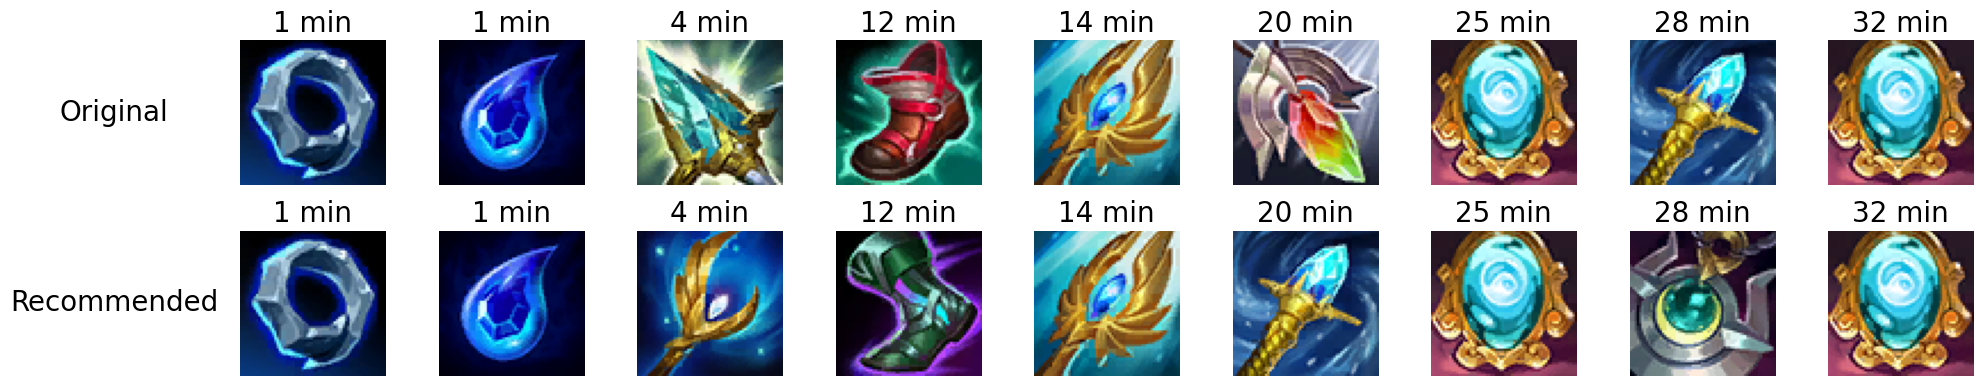

Lane: Top
Rank: Gold
Champion: Quinn
Allies: Ezreal, Khazix, Pantheon, Syndra
Enemies: Azir, Senna, Thresh, Volibear, Warwick


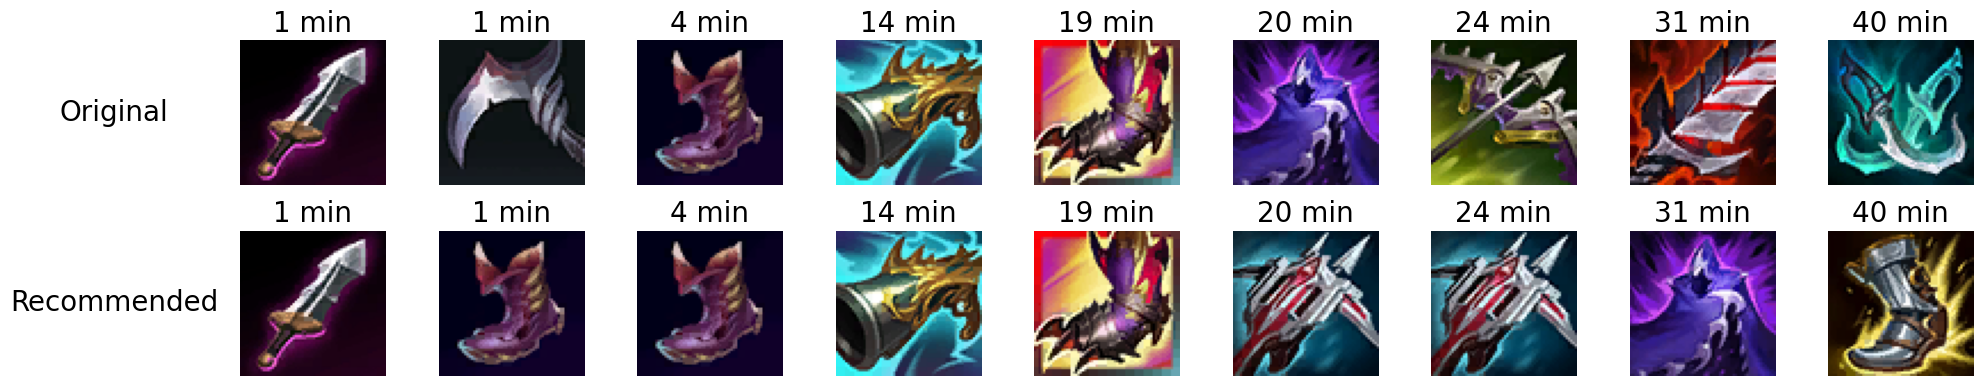

Lane: Jungle
Rank: Platinum
Champion: JarvanIV
Allies: Braum, Ezreal, Leblanc, Shen
Enemies: Alistar, Hwei, Pantheon, Samira, Volibear


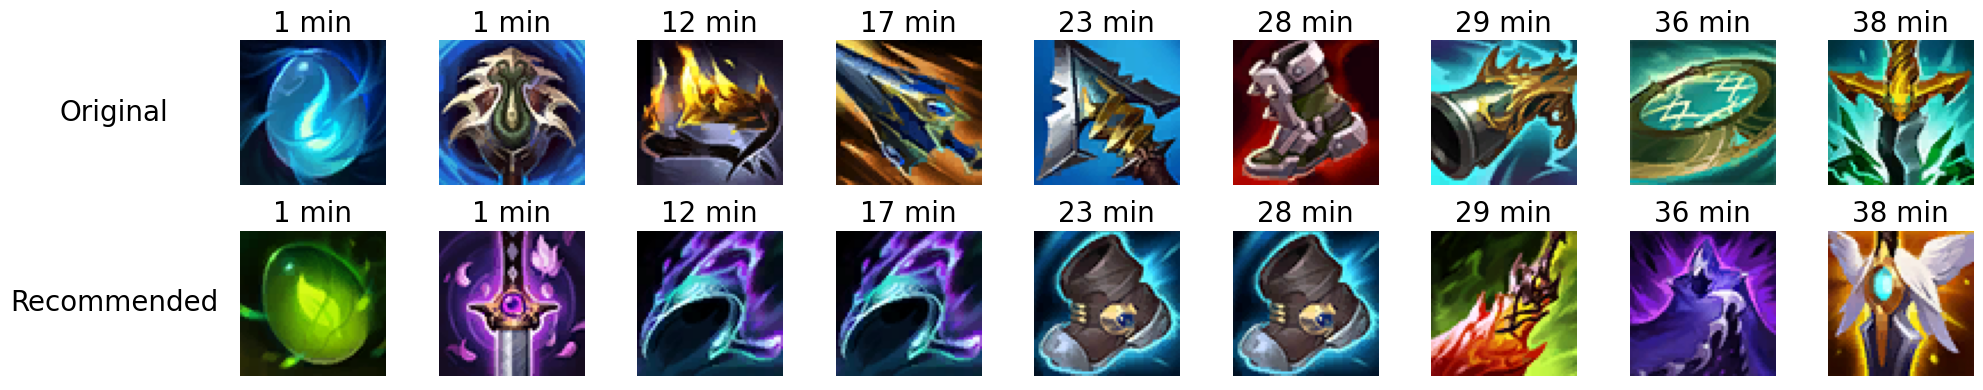

Lane: Bottom
Rank: Silver
Champion: Ezreal
Allies: Bard, MonkeyKing, Rengar, TwistedFate
Enemies: Kayn, Lux, Shen, Smolder, Swain


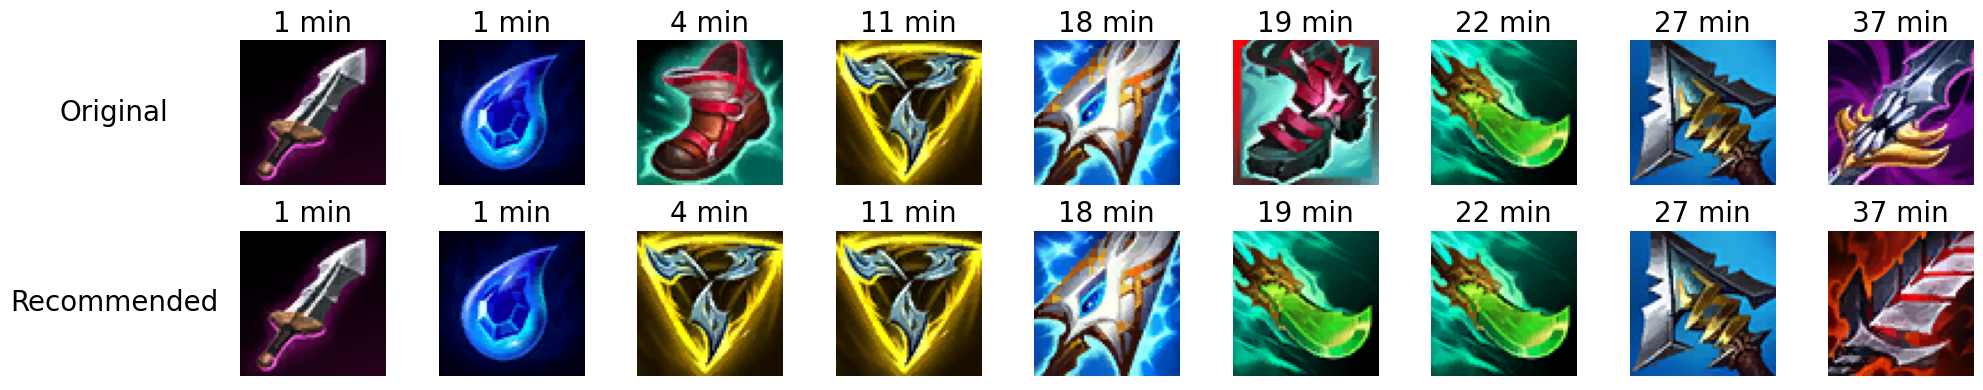

Lane: Utility
Rank: Unranked
Champion: Pantheon
Allies: Kindred, Taliyah, Volibear, Zeri
Enemies: Alistar, Jinx, MonkeyKing, Shen, TwistedFate


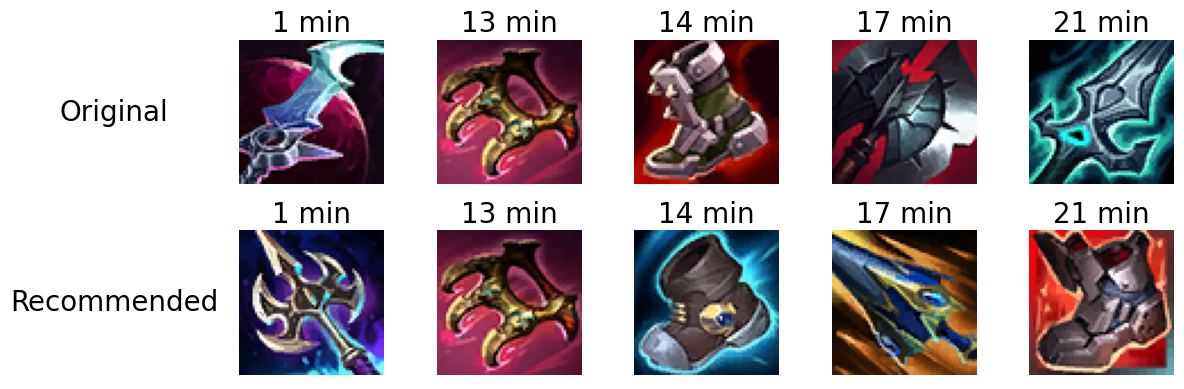

Lane: Jungle
Rank: Grandmaster
Champion: JarvanIV
Allies: Jhin, Kayle, Nami, Orianna
Enemies: Ekko, Ornn, Senna, Talon, Twitch


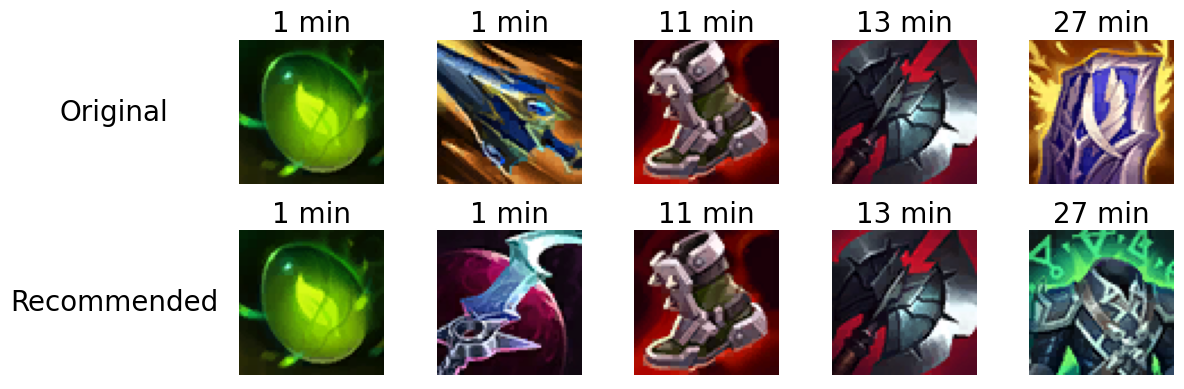

Lane: Top
Rank: Master
Champion: Ambessa
Allies: Akali, Pantheon, Tristana, Zac
Enemies: Gwen, Naafiri, Poppy, Vladimir, Xayah


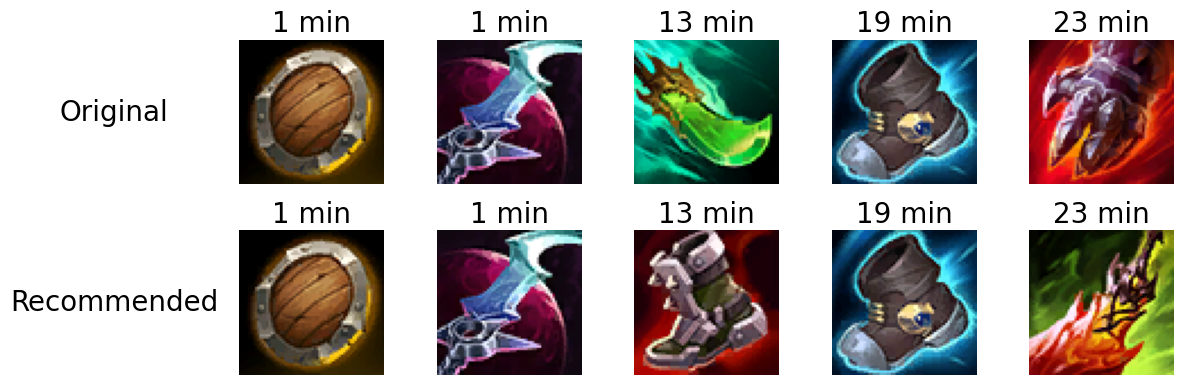

Lane: Jungle
Rank: Unranked
Champion: Kayn
Allies: Blitzcrank, Kaisa, Orianna, Renekton
Enemies: Alistar, Azir, Seraphine, Sett, Shaco


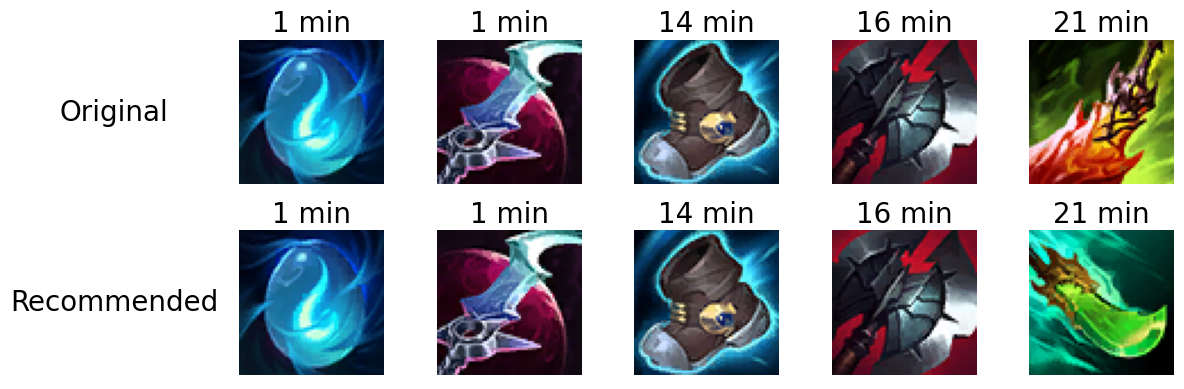

Lane: Top
Rank: Unranked
Champion: Fiddlesticks
Allies: Jhin, Pyke, Syndra, Viego
Enemies: Diana, Draven, Pantheon, Sion, Thresh


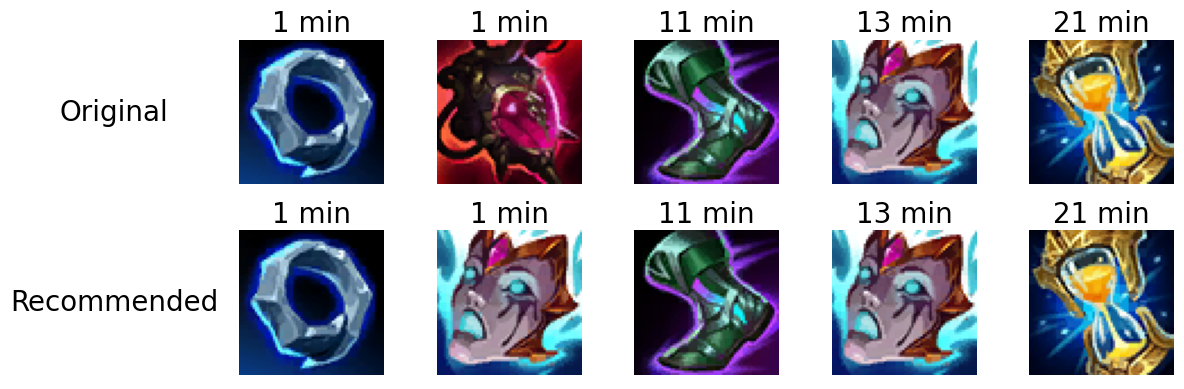

In [ ]:
RANKS = ["UNRANKED", "IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "EMERALD", "DIAMOND", "MASTER", "GRANDMASTER", "CHALLENGER"]

def show_build_comparison(timeframes, original_items, recommended_items):
    n = max(len(original_items), len(recommended_items))
    fig, axs = plt.subplots(2, n + 1, figsize=(2 * (n + 1), 4))  # Wider and taller
    axs[0][0].axis('off')
    axs[1][0].axis('off')
    axs[0][0].text(0.5, 0.5, "Original", fontsize=20, ha='center', va='center')
    axs[1][0].text(0.5, 0.5, "Recommended", fontsize=20, ha='center', va='center')
    for i, item_ids in enumerate([original_items, recommended_items]):
        for j in range(n):
            ax = axs[i][j + 1]
            ax.axis('off')
            ax.set_title(f"{timeframes[j]} min", fontsize=20)
            if j < len(item_ids):
                icon = get_item_icon(item_ids[j])
                if icon is not None:
                    ax.imshow(icon)
    plt.tight_layout()
    plt.show()

def show_build(item_ids, titles=None):
    if not item_ids:
        return None
    n = len(item_ids)
    fig, axs = plt.subplots(1, n, figsize=(2 * n, 2))
    if n == 1:
        axs = [axs]  # ensure iterable
    for i, id in enumerate(item_ids):
        icon = get_item_icon(id)
        if icon:
            axs[i].imshow(icon)
        axs[i].axis('off')
        if titles:
            axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

def show_item(item_id):
    fig, ax = plt.subplots(figsize=(2, 2))
    icon = get_item_icon(item_id)
    if icon:
        ax.imshow(icon)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def get_real_value(normalized_value, global_min, global_max, label):
    return normalized_value * (global_max[label] - global_min[label]) + global_min[label]

def compare_builds(
        info: pd.Series,
        recommended_items: list,
        original_items: list,
        global_min, global_max
        ):

    allies = []
    enemies = []
    perks = []
    lane = ""
    analysed_champion = ""
    # Finding real values for OHE columns
    for col in info[0].index:
        if info[0][col] == 0:
            continue
        if col.startswith("player"):
            analysed_champion = col.split("_")[1]
        elif col.startswith("ally") and not any(substring in col.lower() for substring in ["kda", "level", "kill"]):
            allies.append(col.split("_")[1])
        elif col.startswith("enemy") and not any(substring in col.lower() for substring in ["kda", "level", "kill"]):
            enemies.append(col.split("_")[1])
        elif col.startswith("perk"):
            perks.append(col.split("_")[1])
        elif col in LANES:
            lane = col.lower().capitalize()
    rank = RANKS[int(get_real_value(info[0]["tier"], global_min, global_max, "tier"))].lower().capitalize()

    print(f"Lane: {lane}")
    print(f"Rank: {rank}")
    print(f"Champion: {analysed_champion}")
    print(f"Allies: {', '.join(champ for champ in allies)}")
    print(f"Enemies: {', '.join(champ for champ in enemies)}")
    original_build = []

    last = len(info)
    timeframes = []
    for i in range(len(info)):
        timeframe_values = {
            "timeframe": 0,
            "kda": 0,
            "level": 0,
            "minionsKilled": 0,
            "goldEarned": 0,
            'ally_atakhanKills': 0,
            'ally_baronKills': 0,
            'ally_dragonKills': 0,
            'ally_heraldKills': 0,
            'ally_structuresKilled': 0,
            'ally_voidgrubKills': 0,
            'enemy_atakhanKills': 0,
            'enemy_baronKills': 0,
            'enemy_dragonKills': 0,
            'enemy_heraldKills': 0,
            'enemy_structuresKilled': 0,
            'enemy_voidgrubKills': 0,
        }

        # Hit the mask -- stop showing predictions
        if info[i]["timeframe"] == 0 and i > 0:
            last = i - 1
            break

        for label in timeframe_values:
            timeframe_values[label] = get_real_value(info[i][label], global_min, global_max, label)
        timeframes.append(int((timeframe_values["timeframe"])//(60000)))
        # for col in [col for col in info[i].index if "item_" in col]:
        #     item_id = int(col[col.find("_") + 1:])
        #     # Item was sold
        #     if info[i][col] == 0 and item_id in original_build:
        #         original_build.remove(item_id)
        #     # Item was bought
        #     elif info[i][col] == 1 and item_id not in original_build:
        #         original_build.append(item_id)
        # recommendation = recommended_items[i]
        # true = original_items[i]
        # print(f"Timeframe: {timeframe_values['timeframe']}")
        # print(f"Current build : {', '.join(
        #     [f'{get_item_name(item):<30}' for item in original_build]
        # )}")
        # print("Original build")
        # show_build(original_build)
        # print(f"Recommendation: {get_item_name(recommendation)}")
        # print(f"Actual next item: {get_item_name(true)}")
        # show_build([recommendation, true], ["recommendation", "true"])
    show_build_comparison(timeframes, original_items[:last+1], recommended_items[:last+1])

# Insertion sort (first matches have more dataframes)
for i in range(1, len(timeframe_info)):
    current_info = timeframe_info[i]
    current_rec = recommendations[i]
    current_true = true_items[i]
    n = len([1 for info in current_info if not np.sum(info) == 0])
    j = i - 1
    while j >= 0:
        m = len([1 for info in timeframe_info[j] if not np.sum(info) == 0])
        if n < m:
            break
        timeframe_info[j + 1] = timeframe_info[j]
        recommendations[j + 1] = recommendations[j]
        true_items[j + 1] = true_items[j]
        j -= 1
    timeframe_info[j + 1] = current_info
    recommendations[j + 1] = current_rec
    true_items[j + 1] = current_true

for start in [0, len(timeframe_info) //2 , len(timeframe_info) // 10]:
    for i in range(start, start + 5):
        compare_builds(
            timeframe_info[i],
            recommendations[i],
            true_items[i],
            global_min, global_max
        )